In [1]:
import pyreadstat
import pandas as pd
import numpy as np
import networkx as nx
import warnings
import itertools
from tqdm import tqdm

In [2]:
df, meta = pyreadstat.read_sav("..//data/raw/OD 2017//Banco de Dados//OD_2017.sav")
df.drop_duplicates(subset=['zona', 'zona_esc', 'zonatra1', 'id_pess'], inplace=True)

In [3]:
df = df[df['muni_dom'] == 36]
max_zona = int(df.zona.max())

In [4]:
trab_esc = df[['zona', 'zona_esc', 'zonatra1', 'id_pess', 'id_dom']].copy()
trab_esc.rename(columns={'zona':'home_zone',
                        'zona_esc':'school',
                        'zonatra1':'work',
                        'id_pess': 'id', 'id_dom': 'house_id'}, inplace=True)

trab_esc = trab_esc[~(trab_esc['work'] > max_zona) & 
        ~(trab_esc['school'] > max_zona) & ~(trab_esc['home_zone'] > max_zona)].reset_index(drop=True)

In [5]:
G = nx.Graph()

In [6]:
def add_person_to_graph(person):
    G.add_node(person['id'],
               work = person['work'],
               school = person['school'],
               home = person['home_zone']
    )    
    
trab_esc.apply(add_person_to_graph, axis=1)
print('Adicionando Pessoas')
print(len(G.nodes))
print(len(G.edges))
print(50*'*')

Adicionando Pessoas
55492
0
**************************************************


In [7]:
print('Adicionando Vertices de Casas')

def add_edge(person1, person2, edge_type, edge_zone):
        G.add_edge(person1, person2, edge_type=edge_type, zone=edge_zone)
        
for h in tqdm(trab_esc['house_id'].unique()):
    tmp = trab_esc[trab_esc['house_id'] == h]
    zone = tmp['home_zone'].value_counts().index[0]
    if len(tmp) > 1:
        for p1, p2 in list(itertools.combinations(tmp['id'].values, 2)):
            add_edge(p1, p2, 'house', zone)


print(len(G.nodes))
print(len(G.edges))
print(50*'*')

  0%|                                                                              | 17/21708 [00:00<02:12, 163.90it/s]

Adicionando Vertices de Casas


100%|███████████████████████████████████████████████████████████████████████████| 21708/21708 [02:05<00:00, 172.76it/s]

55492
61634
**************************************************


In [8]:
for w in tqdm(trab_esc['work'].unique()):
    if pd.notna(w):
        tmp = trab_esc[trab_esc['work'] == w]
        zone = tmp['work'].value_counts().index[0]

        if len(tmp) > 1:
            possible_combinations = np.array(list(itertools.combinations(tmp['id'].values, 2)))
            size_comb = int(len(possible_combinations))
            index_combs = np.random.choice(size_comb, size=int(size_comb*.05))
            real_combs = possible_combinations[index_combs]        
            for p1, p2 in real_combs:
                add_edge(p1, p2, 'work', zone)
                
print(len(G.nodes))
print(len(G.edges))
print(50*'*')

100%|███████████████████████████████████████████████████████████████████████████████| 339/339 [00:01<00:00, 239.59it/s]

55492
155873
**************************************************


In [9]:
for s in tqdm(trab_esc['school'].unique()):
    if pd.notna(s):
        tmp = trab_esc[trab_esc['school'] == s]
        zone = tmp['school'].value_counts().index[0]

        if len(tmp) > 1:
            possible_combinations = np.array(list(itertools.combinations(tmp['id'].values, 2)))
            size_comb = int(len(possible_combinations))
            index_combs = np.random.choice(size_comb, size=int(size_comb*.25))
            real_combs = possible_combinations[index_combs]        
            for p1, p2 in real_combs:
                add_edge(p1, p2, 'school', zone)
                
print(len(G.nodes))
print(len(G.edges))
print(50*'*')

100%|███████████████████████████████████████████████████████████████████████████████| 336/336 [00:00<00:00, 419.61it/s]

55492
253707
**************************************************


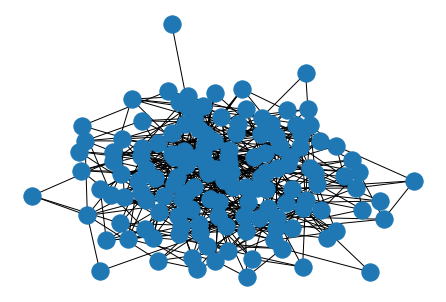

In [23]:
zone1_residents = [x for x,y in G.nodes(data=True) if y['work']==12]
H = G.subgraph(zone1_residents)
nx.draw(H) 

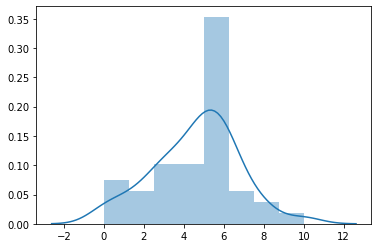

In [11]:
import seaborn as sns
sns.distplot([v for k,v in H.degree])

In [24]:
nx.write_gpickle(G, 'Grafo_Zonas_SP.gpickle')